In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import itertools

In [2]:
##########################################################
# Define resource combinations as in the experiment
CSM = np.zeros((75,16)); # 75 media's 16 cs compositions
for i in np.arange(16): # single resources, 15 resources
    CSM[i,i]=1;
    CSM[58+i, i]= -1/15;
# 2 resource combination, done in manual way to match the experiment
CSM[16,0]=1/2; CSM[16,-1]=1/2; CSM[17,9]=1/2; CSM[17,4]=1/2; CSM[18,1]=1/2; CSM[18,-6]=1/2; CSM[19,-2]=1/2; CSM[19,-3]=1/2; 
CSM[20,2]=1/2; CSM[20,8]=1/2; CSM[21,5]=1/2; CSM[21,6]=1/2; CSM[22,7]=1/2; CSM[22,-4]=1/2; CSM[23,-5]=1/2; CSM[23,3]=1/2; 
CSM[24,7]=1/2; CSM[24,3]=1/2; CSM[25,6]=1/2; CSM[25,-2]=1/2; CSM[26,0]=1/2; CSM[26,-8]=1/2; CSM[27,-3]=1/2; CSM[27,2]=1/2; 
CSM[28,-4]=1/2; CSM[28,-5]=1/2; CSM[29,-6]=1/2; CSM[29,4]=1/2; CSM[30,5]=1/2; CSM[30,9]=1/2; CSM[31,1]=1/2; CSM[31,-1]=1/2; 
CSM[32,-1]=1/2; CSM[32,4]=1/2; CSM[33,5]=1/2; CSM[33,3]=1/2; CSM[34,2]=1/2; CSM[34,-5]=1/2; CSM[35,-3]=1/2; CSM[35,0]=1/2; 
CSM[36,1]=1/2; CSM[36,9]=1/2; CSM[37,8]=1/2; CSM[37,10]=1/2; CSM[38,6]=1/2; CSM[38,7]=1/2; CSM[39,-2]=1/2; CSM[39,-4]=1/2; 
for i in np.arange(4): # 4 resource combinations
    CSM[40+i,:] = 1/4*( CSM[16+i*2]+CSM[16+i*2+1] > 0 );
    CSM[44+i,:] = 1/4*( CSM[24+i*2]+CSM[24+i*2+1] > 0 );
    CSM[48+i,:] = 1/4*( CSM[32+i*2]+CSM[32+i*2+1] > 0 );
for i in np.arange(2): # 8 resource combinations
    CSM[52+i] = 1/8*( CSM[40+i*2]+CSM[40+i*2+1] > 0 );
    CSM[54+i] = 1/8*( CSM[44+i*2]+CSM[44+i*2+1] > 0 );
    CSM[56+i] = 1/8*( CSM[48+i*2]+CSM[48+i*2+1] > 0 );
CSM[58:-1,:]+=1/15; # 15 resources
CSM[-1,:]+=1/16; # 16 resources

In [4]:
######################################################
# Import the 'real' metabolic network, create the resource supply according to tournament structure, and create the cross-feeding matrix
singles = np.array([3,10,14,17,19,21,22,26,28,33,46,49,51,62,63,69]);
singles_names = ['glucose','sucrose','fructose','glycerol','fumarate','citrate','mannose','xylose','cellobiose','maltose','galacturonate','starch','mannitol','cellulose','sorbitol','proline'];
CFm0 = pd.read_csv('data_metabolism/cf_matrix_upper_bound_mergers.csv', names=np.arange(96)); CFm0 = np.array(CFm0);


core_indices = [ 2, 4, 5, 6, 11, 19, 20, 21, 44 ]
for ci, cj in itertools.combinations( core_indices, 2 ):
    CFm0[ ci, cj ] = 1
   
    
CFm1=np.copy(CFm0); # can have CFm modified from CFm0 in principle.

# rows are input, columns are output.
# normalize leakage by number of downstream metabolites to enforce energy conservation
for i in np.arange(np.shape(CFm1)[0]): # CFm1: up -> down
    if(np.sum(CFm1[i] > 0)  ):
        CFm1[i] = CFm1[i]/np.sum(CFm1[i])

CFm=CFm1;
#remap resource combination for supplied resources
a = np.zeros((16,np.shape(CFm)[0]));
for i in np.arange(16):
    a[i,singles[i]]=1;
a[:, core_indices]+=0.2 # add acetate. You can also change 1 to arbitrary value if you want higher/lower acetate supply than the CS supply.
CJ0s = CSM@a;

In [5]:
###########################################################
# code for resource dynamics.
# mortality and resource supply are coupled as dilution d. scale ~ yield.
def CFlog( t, nc, rij, cf, l, cj0, d, scale=1):
# nc is population+concentration, rij is growth rate, cf is consumption+cross-feeding, l is leakage, cj0 is supply, d is dilution, scale sets scale between concentration and population
    S=len(nc)-len(cj0);
    n = nc[:S]; c=nc[S:]; c=c*(c>0);
    dn = (1-l)*np.sum(rij*c, axis=1)-d; 
    consume = c*np.sum(rij.T*np.exp(n), axis=1); 
    dc = - scale*np.matmul( consume, cf ).reshape(len(cj0)) + d *(cj0 - c);
    return np.concatenate([dn,dc]);

In [6]:
##########################################
# code for running over all 75 media.
def CFrun_real( S=96, R=96, D=0.1, l=0.01, c=1, cfm=CFm,  Cj0s=CJ0s, scale=1):
# D is dilution, l is leakage, c is scale of supply concentration, cfm is cross-feeding matrix, Cj0s is supply resource concentrations
    nss = np.zeros((Cj0s.shape[0],S+R))-8; 
    # construct growth rates
    Rij = np.diag(np.random.normal(1,0.01, size=S)  ); # 'specialist' pool
    cf = np.diag(np.ones(R)); cf=cf-l*cfm; # cf consists of consumption + cross-feeding
    for i in tqdm(np.arange( Cj0s.shape[0] )):
        def CF_wrap(t,nc):
            return CFlog(t, nc, rij=Rij, cf=cf, l=l, cj0=c*Cj0s[i], d=D, scale=scale  )
        sol= solve_ivp( CF_wrap, ( 0, 1000 ), y0=np.concatenate( [np.ones(S)*(-7), c*Cj0s[i]] ), method='Radau');
        nss[i,:] = sol.y[:,-1];
    return nss, sol

In [7]:
###########################################
# code for plotting the result
def plot_real(nss, csm=CSM, th=0):
# th is an arbitrary threshold for counting the number of metabolites
    fig, ax = plt.subplots(2,2, figsize=(10,12), facecolor='white');
    S = np.shape(nss)[-1]//2;
    surv = 1*((nss[:,:S])>-7);
    media = 1*(nss[:,S:]>th);
    # define specialists and generalists
    spstat = np.sum(surv[:16], axis=0);
    restat = np.sum(media[:16], axis=0);
    richness = np.sum(surv, axis=1);
    nmet = np.sum(media, axis=1);
    special = np.where( (spstat>0)*(spstat<4) )[0]; nspe = np.sum(surv[:16,special], axis=1);
    inter = np.where( (spstat>3)*(spstat<14) )[0]; nint = np.sum(surv[:16,inter], axis=1);
    general = np.where( (spstat>13) )[0]; ngen = np.sum(surv[:16,general], axis=1);
    peri = np.where( (restat>0)*(restat<4) )[0]; nperi = np.sum(media[:16,peri], axis=1);
    interm = np.where( (restat>3)*(restat<14) )[0]; nintm = np.sum(media[:16,interm], axis=1);
    core = np.where( (restat>13) )[0]; ncore = np.sum(media[:16,core], axis=1);
    
    ax[0,0].bar(singles_names,ngen, color='#f5a28f')
    ax[0,0].bar(singles_names,nint, bottom=ngen, color='#e5dec2')
    ax[0,0].bar(singles_names,nspe, bottom=ngen+nint, color='#87babb')
    
    ax[0,1].bar(singles_names,ncore, color='#f5a28f')
    ax[0,1].bar(singles_names,nintm, bottom=ncore, color='#e5dec2')
    ax[0,1].bar(singles_names,nperi, bottom=ncore+nintm, color='#87babb')
    
    ax[0,0].set_xticklabels(labels=singles_names, rotation=90)
    ax[0,1].set_xticklabels(labels=singles_names, rotation=90)
    
    nrs = np.zeros((6,2,2));
    for i in np.arange(6):
        nr = [1,2,4,8,15,16][i]; 
        target = np.where(np.sum(csm>0, axis=1)==nr)[0]; survt = surv[target]; mediat=media[target];
        ax[1,0].bar( nr, np.sum(survt[:,general])/len(target), color='#f5a28f' );
        ax[1,0].bar( nr, np.sum(survt[:,inter])/len(target), bottom=np.sum(survt[:,general])/len(target), color='#e5dec2' );
        ax[1,0].bar( nr, np.sum(survt[:,special])/len(target), bottom=np.sum(survt[:,general])/len(target)+np.sum(survt[:,inter])/len(target), color='#87babb' );
        ax[1,1].bar( nr, np.sum(mediat[:,core])/len(target), color='#f5a28f' );
        ax[1,1].bar( nr, np.sum(mediat[:,interm])/len(target), bottom=np.sum(mediat[:,core])/len(target), color='#e5dec2' );
        ax[1,1].bar( nr, np.sum(mediat[:,peri])/len(target), bottom=np.sum(mediat[:,core])/len(target)+np.sum(mediat[:,interm])/len(target), color='#87babb' );
        nrs[i,0,0] = np.average(richness[target], axis=0);
        nrs[i,0,1] = np.std(richness[target], axis=0)/np.sqrt(len(target));
        nrs[i,1,0] = np.average(nmet[target], axis=0);
        nrs[i,1,1] = np.std(nmet[target], axis=0)/np.sqrt(len(target));
    ax[1,0].errorbar([1,2,4,8,15,16], nrs[:,0,0], yerr=nrs[:,0,1], color='k' );
    ax[1,1].errorbar([1,2,4,8,15,16], nrs[:,1,0], yerr=nrs[:,1,1], color='k' );
    ax[1,0].set_xlabel('Number of CS');
    ax[1,0].set_ylabel('Richness');
    ax[0,0].set_ylabel('Richness');
    ax[1,1].set_xlabel('Number of CS');
    ax[1,1].set_ylabel('Number of metabolites');
    ax[0,1].set_ylabel('Number of metabolites');
    plt.savefig('trend.pdf')
    return fig, ax, nrs

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:04<00:00,  1.16it/s]
<ipython-input-7-312abc504458>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels=singles_names, rotation=90)
<ipython-input-7-312abc504458>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(labels=singles_names, rotation=90)


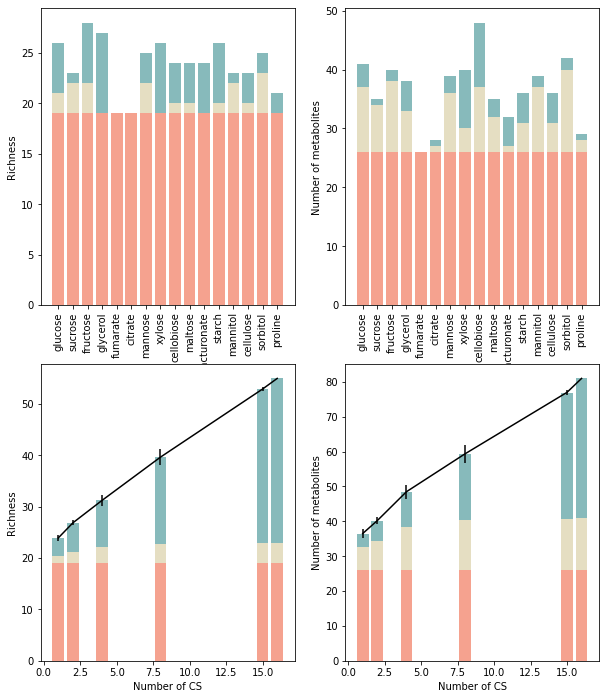

In [8]:
##################################
# sample run (takes 2 mins in colab)
nss, sol = CFrun_real(l=0.1, D=0.1, c=100, Cj0s=CJ0s, scale=1);
# sample visualization
fig, ax, nrs = plot_real(nss, th=0.)